#  Count Vectorization Model and Vader Sentiment Analysis
---

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression

from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

In [2]:
reddit_df= pd.read_csv('../data/reddit_df.csv')

In [3]:
reddit_df.head()

,subreddit,author,locked,num_comments,selftext,title,timestamp,full_text,full_text_clean
0,1,AutoModerator,0,84,"[Previous](/r/AskHistorians/search?q=title%3A""...",Sunday Digest | Interesting &amp; Overlooked P...,2019-07-07 14:04:52,Sunday Digest | Interesting &amp; Overlooked P...,sunday digest interesting amp overlooked post ...
1,1,AutoModerator,0,1,[Previous weeks!](/r/AskHistorians/search?sort...,"Short Answers to Simple Questions | July 10, 2019",2019-07-10 14:05:16,"Short Answers to Simple Questions | July 10, 2...",short answer simple question july 10 2019 prev...
2,1,tiikerinsilma,0,26,I'm asking this partially because the atrociti...,"(WW2) Did Japan have genocidal plans for Asia,...",2019-07-10 09:09:07,"(WW2) Did Japan have genocidal plans for Asia,...",ww2 japan genocidal plan asia war asking parti...
3,1,Mr_Quinn,0,10,NaN,"In 1627 the last aurochs, or wild cow, died in...",2019-07-10 14:00:39,"In 1627 the last aurochs, or wild cow, died in...",1627 last aurochs wild cow died jaktor w fores...
4,1,Erezen,0,14,"Moreover, how was the movie received in South ...","""The Gods Must Be Crazy"" is a beloved South Af...",2019-07-09 20:36:09,"""The Gods Must Be Crazy"" is a beloved South Af...",god must crazy beloved south african movie rel...


In [4]:
X= reddit_df['full_text_clean']
y= reddit_df['subreddit']

X_train, X_test, y_train, y_test= train_test_split(X, y, stratify=y, random_state= 22)

In [5]:
cvec = CountVectorizer(ngram_range=(1,2), stop_words=['askhistorians'])

X_train_vec = cvec.fit_transform(X_train) 
X_test_vec = cvec.transform(X_test)

In [6]:
X_train_df = pd.DataFrame(X_train_vec.toarray(), columns = cvec.get_feature_names())
X_test_df = pd.DataFrame(X_test_vec.toarray(), columns = cvec.get_feature_names())

In [7]:
lr = LogisticRegression()

lr.fit(X_train_df, y_train)
lr.score(X_train_df, y_train)

C:\Users\flake\Anaconda3\envs\GA_DSI\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.998997995991984

In [8]:
lr.score(X_test_df, y_test)

0.9248496993987976

**Train Accuracy** = $0.999$

**Test Accuracy** = $0.924$

In [9]:
y_pred = lr.predict(X_test_vec)

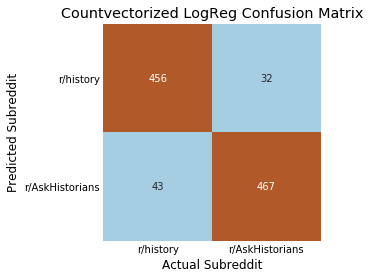

In [10]:
con_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(con_mat.T, cmap='Paired', square=True, annot=True, fmt='d', cbar=False,
           xticklabels=['r/history', 'r/AskHistorians'],
           yticklabels=['r/history', 'r/AskHistorians']
           )

plt.yticks(rotation=0)
plt.xlabel('Actual Subreddit')
plt.ylabel('Predicted Subreddit')
plt.title('Countvectorized LogReg Confusion Matrix');

A easy way of looking at the confusion matrix.  Actual calculations are done below with the .ravel() method but this is more pleasing to the eye.  Note that the matrix is transposed so the x-axis is the actual subreddit and the y-axis is the predicted subreddit.

In [11]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()

**Specificity and Sensitivity**

In [12]:
print(f'Specificity: {round(tn / (fp + tn), 2)}')

print(f'Sensitivity: {round(tp /(tp + fn), 2)}')

Specificity: 0.91
Sensitivity: 0.94


**Specificity:** $0.91$

**Sensitivity:** $0.94$
    
The model predicts the positive class (r/AskHistorians) well, which is what I had hoped for.

**F1 Score:** $0.926$

In [13]:
round(f1_score(y_test, y_pred),3)

0.926

In [14]:
cross_val_score(lr, X_train_vec, y_train, cv=20, n_jobs=4).mean()

0.9051036036036038

**Cross Validation Score ($k=20$):** $0.905$

In [15]:
coefs = (np.exp(lr.coef_))[0]
         
features = cvec.get_feature_names()

feat_dict = dict(zip(features, coefs))

In [16]:
coef_df = pd.DataFrame.from_dict(feat_dict, orient='index')
coef_df.columns = ['Coef']
coef_df.sort_values(by='Coef', ascending=False).head(20)

,Coef
north,2.146758
heard,1.837305
use,1.827294
practice,1.758607
later,1.746607
source,1.741636
woman,1.672080
support,1.612254
kind,1.610583
south,1.596305


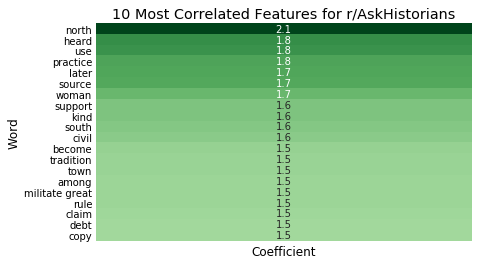

In [17]:
sns.heatmap(coef_df.sort_values(by='Coef', ascending=False).head(20), 
            cmap='PRGn',
            vmin=0,
            annot=True,
            cbar=False,
            xticklabels=False
           )
plt.title('10 Most Correlated Features for r/AskHistorians')
plt.ylabel('Word')
plt.xlabel('Coefficient');

Visualizing the 10 most correlated features.  

### Vader Sentiment Analysis

In [18]:
sia = SentimentIntensityAnalyzer()

In [19]:
list_of_scores = []

for post in X_train:
    scores = sia.polarity_scores(post)
    list_of_scores.append(scores)

In [20]:
train_scores_df= pd.DataFrame(list_of_scores)
train_scores_df

,compound,neg,neu,pos
0,0.0000,0.000,1.000,0.000
1,-0.9607,0.378,0.569,0.054
2,0.9349,0.083,0.565,0.352
3,-0.1280,0.333,0.444,0.222
4,0.9682,0.000,0.680,0.320
5,-0.9643,0.257,0.620,0.123
6,-0.1280,0.158,0.672,0.171
7,0.8516,0.000,0.660,0.340
8,0.9403,0.061,0.467,0.472
9,0.4767,0.167,0.602,0.231


#### Overall Sentiment Analysis scores:

| Score| mean|
|---------|---------| 
|Compound | 0.147|     
|Negative | 0.108|
|Neutral  | 0.747|
|Positive  | 0.145|

In [21]:
X_train_df = pd.concat(objs=[X_train_df, train_scores_df], axis=1)

In [22]:
list_of_scores = []

for post in X_test:
    scores = sia.polarity_scores(post)
    list_of_scores.append(scores)
    
test_scores_df= pd.DataFrame(list_of_scores)

X_test_df = pd.concat(objs=[X_test_df, test_scores_df], axis=1)

In [23]:
lordVader= LogisticRegression()

lordVader.fit(X_train_df, y_train)
lordVader.score(X_train_df, y_train)

C:\Users\flake\Anaconda3\envs\GA_DSI\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.998997995991984

In [24]:
lordVader.score(X_test_df, y_test)

0.9228456913827655

**Accuracy:**

Train: $0.999$

Test: $0.937$

In [25]:
y_pred_vader = lordVader.predict(X_test_df)

In [26]:
tn_lv, fp_lv, fn_lv, tp_lv = confusion_matrix(y_test,y_pred_vader).ravel()

In [27]:
print(f'Specificity: {round(tn_lv / (fp_lv + tn_lv), 2)}')

print(f'Sensitivity: {round(tp_lv /(tp_lv + fn_lv), 2)}')

Specificity: 0.91
Sensitivity: 0.94


**Specificity:** 0.92

**Sensitivity:** 0.96
    

In [28]:
# F1 score

round(f1_score(y_test, y_pred_vader),3)

0.924

**F1 score:** $0.938$

Adding vader sentiment analysis did not improve model at all which makes sense considering most posts/selftexts aren't going to slant either way in academia focused subs.  


In [29]:
train_scores_df.mean()

compound    0.148514
neg         0.107773
neu         0.748094
pos         0.144141
dtype: float64

Text(0.5, 1.0, 'Neutral Sentiment Score')

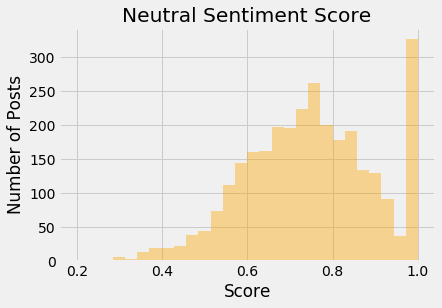

In [30]:
style.use('fivethirtyeight')
sns.distplot(train_scores_df['neu'], color='orange', kde=False);
plt.ylabel('Number of Posts')
plt.xlabel('Score')
plt.title('Neutral Sentiment Score')

Text(0.5, 1.0, 'Postive Sentiment Score')

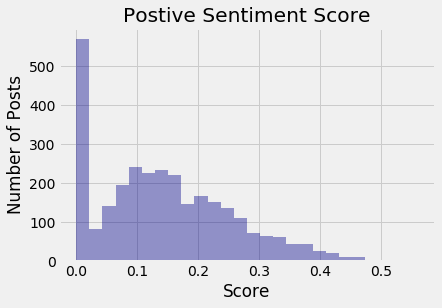

In [33]:
style.use('fivethirtyeight')
sns.distplot(train_scores_df['pos'], color='darkblue', kde=False);
plt.ylabel('Number of Posts')
plt.xlabel('Score')
plt.title('Negative Sentiment Score')

Text(0.5, 1.0, 'Negative Sentiment Score')

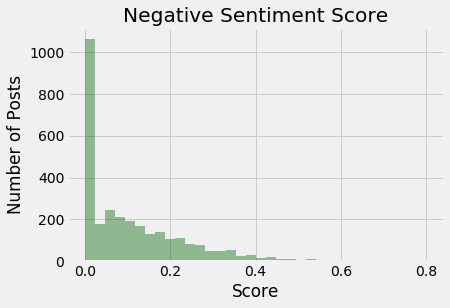

In [34]:
style.use('fivethirtyeight')
sns.distplot(train_scores_df['neg'], color='darkgreen', kde=False);
plt.ylabel('Number of Posts')
plt.xlabel('Score')
plt.title('Negative Sentiment Score')